# UFC fight predictor

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
#produces a prediction model in the form of an ensemble of weak prediction models, typically decision tree
import xgboost as xgb
#the outcome (dependent variable) has only a limited number of possible values. 
#Logistic Regression is used when response variable is categorical in nature.
from sklearn.linear_model import LogisticRegression
#A random forest is a meta estimator that fits a number of decision tree classifiers 
#on various sub-samples of the dataset and use averaging to improve the predictive 
#accuracy and control over-fitting.
from sklearn.ensemble import RandomForestClassifier
#a discriminative classifier formally defined by a separating hyperplane.
from sklearn.svm import SVC
#displayd data
from IPython.display import display
%matplotlib inline

In [3]:
fighters = pd.read_csv('fighters.csv')

In [4]:
fighters.head()
#display(data.head())

,Name,Height,Weight,Division,Reach,Birth_date,ID,Style,Wins
0,Leon Edwards,74.0,170.0,Middleweight,74.0,1991-08-25,852,Boxing,18
1,Rafael dos Anjos,68.0,170.0,Welterweight,70.0,1984-10-26,1138,BJJ,29
2,Walt Harris,77.0,258.0,Heavyweight,81.0,1983-06-10,1437,Karate,13
3,Aleksei Oleinik,74.0,235.0,Heavyweight,80.0,1977-06-25,28,BJJ,34
4,Greg Hardy,77.0,265.0,Heavyweight,80.5,1988-07-28,519,Boxing,5


In [5]:
Win_style = fighters[['Wins','Style']].groupby('Style').sum().reset_index()

In [6]:
Merge1 = fighters[['Name', 'Height', 'Weight', 'Reach', 'Birth_date', "Style"]].copy(deep =True)

In [7]:
Merge1.shape

(1451, 6)

In [8]:
#Create a dictionary with key as style and values as the winning ratio for that style- 
#the work for which has been done in Statistical analysis project previously
styleTransform ={}
for swag in Win_style['Style']:
    styleTransform[swag]= int(Win_style.loc[Win_style.Style== swag,'Wins'])/Win_style['Wins'].sum()
#styleTransform

In [9]:
Merge1['Style'] = Merge1['Style'].apply(lambda x: styleTransform[x])   
Merge1.head()

,Name,Height,Weight,Reach,Birth_date,Style
0,Leon Edwards,74.0,170.0,74.0,1991-08-25,0.199933
1,Rafael dos Anjos,68.0,170.0,70.0,1984-10-26,0.385006
2,Walt Harris,77.0,258.0,81.0,1983-06-10,0.044166
3,Aleksei Oleinik,74.0,235.0,80.0,1977-06-25,0.385006
4,Greg Hardy,77.0,265.0,80.5,1988-07-28,0.199933


In [10]:
dob = pd.to_datetime(Merge1['Birth_date'], errors='coerce')
now = pd.to_datetime('now')
Merge1['Age']= (now - dob).astype('<m8[Y]') 
Merge1 =Merge1.drop(['Birth_date'], axis = 1)

In [11]:
Merge1.head()

,Name,Height,Weight,Reach,Style,Age
0,Leon Edwards,74.0,170.0,74.0,0.199933,27.0
1,Rafael dos Anjos,68.0,170.0,70.0,0.385006,34.0
2,Walt Harris,77.0,258.0,81.0,0.044166,36.0
3,Aleksei Oleinik,74.0,235.0,80.0,0.385006,42.0
4,Greg Hardy,77.0,265.0,80.5,0.199933,31.0


In [12]:
fights = pd.read_csv('fights.csv')

In [13]:
#sort it by date ascending
#a =a.merge(b, on = 'Name'); a['Date']=a['Date'].str.extract(r'(\d{4})'); 
fights['Date'] = fights['Date'].str.extract(r'(\d{4})')

In [14]:
fights= fights.sort_values(by=['Date'], ascending = True)
fights.head()

,Fighter_name,Result,Record,Opponent,Method,Event,Date,Round,Time
33219,Satoshi Honma,Loss,1-1,Kazuhiro Kusayanagi,Submission (triangle choke),Shooto - Shooto,1990,1,1:17
33220,Satoshi Honma,Win,1-0,Yutaka Fuji,Submission (armbar),Shooto - Shooto,1990,2,2:36
34653,Fabio Gurgel,Win,1–0,Denilson Maia,Submission (Punches),Desafio: Jiu-Jitsu vs. Luta Livre,1991,1,9:55
33217,Satoshi Honma,Win,3-1-1,Manabu Yamada,Submission (armbar),Shooto - Shooto,1991,4,NaN
33218,Satoshi Honma,Win,2-1-1,Yoshimasa Ishikawa,Submission (armbar),Shooto - Shooto,1991,2,NaN


In [15]:
#extract method
import re
def get_method(el):
    try:
        r = re.compile(r'.*\((.*)\)$')
        m = r.match(el)
        if m == None:
            return el
        else:
            return m.group(1)
    except:
        return el

In [16]:
fights['Method']= fights['Method'].apply(lambda x:get_method(x))
fights.head()

,Fighter_name,Result,Record,Opponent,Method,Event,Date,Round,Time
33219,Satoshi Honma,Loss,1-1,Kazuhiro Kusayanagi,triangle choke,Shooto - Shooto,1990,1,1:17
33220,Satoshi Honma,Win,1-0,Yutaka Fuji,armbar,Shooto - Shooto,1990,2,2:36
34653,Fabio Gurgel,Win,1–0,Denilson Maia,Punches,Desafio: Jiu-Jitsu vs. Luta Livre,1991,1,9:55
33217,Satoshi Honma,Win,3-1-1,Manabu Yamada,armbar,Shooto - Shooto,1991,4,NaN
33218,Satoshi Honma,Win,2-1-1,Yoshimasa Ishikawa,armbar,Shooto - Shooto,1991,2,NaN


In [17]:
fights['PF1']= 0; fights['PF2']= 0; fights['PF3']= 0; fights['PF4']= 0; fights['PF5']= 0
#PF1-PF5-> past fight results{win:1; loss:-1; no fight=0}

In [18]:
fights['ID'] = fights.groupby('Fighter_name').ngroup()
#tempo = fights.head(30)

In [19]:
# doneID =[]
# for i in range(len(fights.index)):
#     if fights['ID'].values[i] not in doneID:
#         c=i
#         for j in range(i+1,len(fights.index)):
#             if fights['ID'].values[j]==fights['ID'].values[i]:
#                 fights['PF5'].values[j]=fights['PF4'].values[c]; fights['PF4'].values[j]=fights['PF3'].values[c]; fights['PF3'].values[j]= fights['PF2'].values[c]; fights['PF2'].values[j]= fights['PF1'].values[c]
#                 if fights['Result'].values[c]=='Win':
#                     fights['PF1'].values[j]= 1
#                     c=j
#                 else:
#                     fights['PF1'].values[j]= -1
#                     c=j
#         doneID.append(fights['ID'].values[i])                 

In [21]:
fights.head()

,Fighter_name,Result,Record,Opponent,Method,Event,Date,Round,Time,PF1,PF2,PF3,PF4,PF5,ID
33219,Satoshi Honma,Loss,1-1,Kazuhiro Kusayanagi,triangle choke,Shooto - Shooto,1990,1,1:17,0,0,0,0,0,1262
33220,Satoshi Honma,Win,1-0,Yutaka Fuji,armbar,Shooto - Shooto,1990,2,2:36,-1,0,0,0,0,1262
34653,Fabio Gurgel,Win,1–0,Denilson Maia,Punches,Desafio: Jiu-Jitsu vs. Luta Livre,1991,1,9:55,0,0,0,0,0,454
33217,Satoshi Honma,Win,3-1-1,Manabu Yamada,armbar,Shooto - Shooto,1991,4,NaN,1,-1,0,0,0,1262
33218,Satoshi Honma,Win,2-1-1,Yoshimasa Ishikawa,armbar,Shooto - Shooto,1991,2,NaN,1,1,-1,0,0,1262


In [22]:
# header = ["Fighter_name", "Result", "Record", "Opponent", "Method","Event","Date", "Round","Time","PF1","PF2","PF3","PF4", "PF5","ID"]
# fights.to_csv("fighterWithPF.csv", columns = header, index = False)

In [23]:
fights.isnull().sum(axis =0)

Fighter_name       0
Result             0
Record             0
Opponent           0
Method            52
Event              1
Date               1
Round            228
Time            1521
PF1                0
PF2                0
PF3                0
PF4                0
PF5                0
ID                 0
dtype: int64

In [24]:
#Combining Time and Round to get total time. Dropping the ones without values.
fights= fights.dropna(subset =['Time','Round','Method']).reset_index()
#Generating total time
ooo = []
for i in range(len(fights['Time'])):
    if ':' in fights['Time'][i]:
        oo= fights['Time'][i].split(':')
    elif';' in fights['Time'][i]:
        oo = fights['Time'][i].split(';')
    else:
        oo = fights['Time'][i].split('.')
    try:
        ooo += [(int(oo[0])*60+int(oo[1]))*int(fights['Round'][i])/60]
    except:
        ooo+= [float('Nan')]  
fights['totalTime'] = ooo 

In [27]:
fights = fights.dropna(subset = ['totalTime']).reset_index()
fights.head()

,level_0,index,Fighter_name,Result,Record,Opponent,Method,Event,Date,Round,Time,PF1,PF2,PF3,PF4,PF5,ID,totalTime
0,0,33219,Satoshi Honma,Loss,1-1,Kazuhiro Kusayanagi,triangle choke,Shooto - Shooto,1990,1,1:17,0,0,0,0,0,1262,1.283333
1,1,33220,Satoshi Honma,Win,1-0,Yutaka Fuji,armbar,Shooto - Shooto,1990,2,2:36,-1,0,0,0,0,1262,5.200000
2,2,34653,Fabio Gurgel,Win,1–0,Denilson Maia,Punches,Desafio: Jiu-Jitsu vs. Luta Livre,1991,1,9:55,0,0,0,0,0,454,9.916667
3,3,32352,Murilo Bustamante,Win,1–0,Marcelo Mendes,injury,Desafio-Jiu-Jitsu vs. Luta Livre,1991,1,4:42,0,0,0,0,0,1033,4.700000
4,4,33216,Satoshi Honma,Loss,3-2-1,Kenji Kawaguchi,Decision,Shooto - Shooto,1991,5,3:00,1,1,1,-1,0,1262,15.000000


In [29]:
#fights.isnull().sum(axis =0)

In [31]:
#Curate win and loss
Merge2= fights.drop(['Event','Date', 'Record', 'Round','Time','level_0','index'], axis =1)
Merge2.head()

,Fighter_name,Result,Opponent,Method,PF1,PF2,PF3,PF4,PF5,ID,totalTime
0,Satoshi Honma,Loss,Kazuhiro Kusayanagi,triangle choke,0,0,0,0,0,1262,1.283333
1,Satoshi Honma,Win,Yutaka Fuji,armbar,-1,0,0,0,0,1262,5.200000
2,Fabio Gurgel,Win,Denilson Maia,Punches,0,0,0,0,0,454,9.916667
3,Murilo Bustamante,Win,Marcelo Mendes,injury,0,0,0,0,0,1033,4.700000
4,Satoshi Honma,Loss,Kenji Kawaguchi,Decision,1,1,1,-1,0,1262,15.000000


In [32]:
len(Merge2.index)

33287

In [33]:
def helperfunc(x,y):
    a= []
    att = ['Height','Weight','Reach',"Age"]
    for one in att:
        #print(one)
        a+= [Merge1.loc[Merge1.Name == x,[one]].values[0][0]-Merge1.loc[Merge1.Name == y,[one]].values[0][0]]
        #print(a)
    a+= [Merge1.loc[Merge1.Name == x,['Style']].values[0][0]]
    a+= [Merge1.loc[Merge1.Name == y,['Style']].values[0][0]]
    return a

In [34]:
# #Height_diff, Weightdiff, Reachdiff, Agediff, Ownstyle, Opponentstyle
# #def addingfeatures():
# Hd=[];Wd=[];Rd=[];Ad=[];Ws=[];Ps=[]
# Total=[Hd, Wd, Rd, Ad, Ws, Ps]
# c=0
# for i in range(len(Merge2.index)):
# #for i in range(50) :  
#     try:
#         b= helperfunc(Merge2.loc[i,'Fighter_name'],Merge2.loc[i,'Opponent'])
#         #print(Merge2.loc[i,'Fighter_name'],Merge2.loc[i,'Opponent'])
#         #print(b)
#         for j in range(6):
#             Total[j]+= [b[j]]
#         #print(Merge2.loc[i,'Fighter_name'])
#     except:
#         c+=1
#         #print(Merge2.loc[i,'Fighter_name'],Merge2.loc[i,'Opponent'])
#         for j in range(6):
#             Total[j]+= [float('NaN')]
# print(c)

19692


# Acronyms
Hd = Height difference <br>
Wd = Weight difference <br>
Rd = Reach difference <br>
Ad = Age difference <br>
Ws = Own style <br>
Ps = Opponent style <br>

In [35]:
# Title = ['Hd','Wd','Rd',"Ad",'Ws',"Ps"]
# for i in range(6):
#     Merge2[Title[i]]=Total[i]

In [38]:
Merge2.head()

,Fighter_name,Result,Opponent,Method,PF1,PF2,PF3,PF4,PF5,ID,totalTime,Hd,Wd,Rd,Ad,Ws,Ps
0,Satoshi Honma,Loss,Kazuhiro Kusayanagi,triangle choke,0,0,0,0,0,1262,1.283333,NaN,NaN,NaN,NaN,NaN,NaN
1,Satoshi Honma,Win,Yutaka Fuji,armbar,-1,0,0,0,0,1262,5.200000,NaN,NaN,NaN,NaN,NaN,NaN
2,Fabio Gurgel,Win,Denilson Maia,Punches,0,0,0,0,0,454,9.916667,NaN,NaN,NaN,NaN,NaN,NaN
3,Murilo Bustamante,Win,Marcelo Mendes,injury,0,0,0,0,0,1033,4.700000,NaN,NaN,NaN,NaN,NaN,NaN
4,Satoshi Honma,Loss,Kenji Kawaguchi,Decision,1,1,1,-1,0,1262,15.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# header = ["Fighter_name", "Result", "Opponent", "Method","PF1","PF2","PF3","PF4", "PF5","ID",'totalTime',"Hd","Wd","Rd","Ad","Ws","Ps"]
# Merge2.to_csv("fighterWPFnDiff.csv", columns = header, index = False)

In [40]:
Merge =Merge2.dropna(subset =['Ad','Wd','Rd','totalTime']).reset_index(drop =True)
Merge.isnull().sum()

Fighter_name    0
Result          0
Opponent        0
Method          0
PF1             0
PF2             0
PF3             0
PF4             0
PF5             0
ID              0
totalTime       0
Hd              0
Wd              0
Rd              0
Ad              0
Ws              0
Ps              0
dtype: int64

In [44]:
Merge.tail()

,Fighter_name,Result,Opponent,Method,PF1,PF2,PF3,PF4,PF5,ID,totalTime,Hd,Wd,Rd,Ad,Ws,Ps
13324,Curtis Millender,Loss,Belal Muhammad,unanimous,1,1,1,1,1,284,15.000000,4.0,1.000000,4.000000,0.0,0.113599,0.113599
13325,Curtis Millender,Loss,Elizeu Zaleski dos Santos,rear-naked choke,-1,1,1,1,1,284,2.583333,3.0,7.875934,3.502415,-1.0,0.113599,0.199933
13326,Randa Markos,Win,Angela Hill,armbar,1,-1,-1,1,1,1143,4.400000,1.0,0.000000,-0.500000,1.0,0.050826,0.113599
13327,Montel Jackson,Win,Andre Soukhamthath,unanimous,1,1,1,1,-1,1031,15.000000,1.0,0.000000,-4.385542,-3.0,0.123423,0.385006
13328,Leon Edwards,Win,Rafael dos Anjos,unanimous,1,1,1,1,1,852,25.000000,6.0,0.000000,4.000000,-7.0,0.199933,0.385006


# See the correaltion and then convert Method to no-object.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000179469DA4E0>,
      dtype=object)

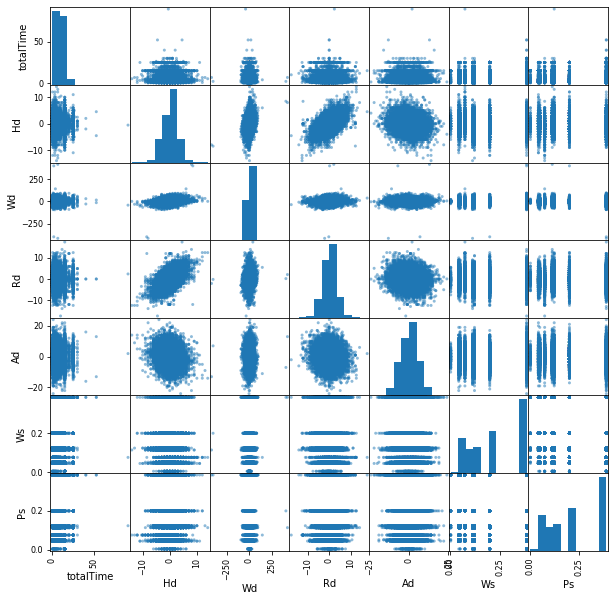

In [45]:
# Visualising distribution of data
from pandas.plotting import scatter_matrix
scatter_matrix(Merge[['totalTime','Hd','Wd', 'Rd','Ad','Ws','Ps']], figsize=(10,10))

Transforming methods to non-object values

In [56]:
Ready_feed =pd.get_dummies(Merge.drop(['Fighter_name','Opponent','ID'], axis =1), columns=["Method"])

In [59]:
Ready_feed.head()

,Result,PF1,PF2,PF3,PF4,PF5,totalTime,Hd,Wd,Rd,...,Method_twister,Method_uanimous,Method_unanimous,Method_upkick,Method_upkick and punch,Method_upkick and punches,Method_verbal,Method_von flue choke,Method_wheel kick,Method_wheel kick and punches
0,Loss,0,0,0,0,0,4.333333,2.000,-35.000000,-3.063542,...,0,0,0,0,0,0,0,0,0,0
1,Win,0,0,0,0,0,1.733333,-4.000,-40.000000,-0.047569,...,0,0,0,0,0,0,0,0,0,0
2,Loss,0,0,0,0,0,12.383333,0.536,8.894823,2.936458,...,0,0,0,0,0,0,0,0,0,0
3,Loss,0,0,0,0,0,1.816667,1.000,15.000000,2.936458,...,0,0,0,0,0,0,0,0,0,0
4,Win,0,0,0,0,0,12.383333,-0.536,-8.894823,-2.936458,...,0,0,0,0,0,0,0,0,0,0


In [62]:
Ready_feed.columns

Index(['Result', 'PF1', 'PF2', 'PF3', 'PF4', 'PF5', 'totalTime', 'Hd', 'Wd',
       'Rd',
       ...
       'Method_twister', 'Method_uanimous', 'Method_unanimous',
       'Method_upkick', 'Method_upkick and punch', 'Method_upkick and punches',
       'Method_verbal', 'Method_von flue choke', 'Method_wheel kick',
       'Method_wheel kick and punches'],
      dtype='object', length=316)

In [166]:
#Let's see the distribution with gaussian fit (The columns needs to be changed to integers for this better working)

featurenames = Ready_feed.columns

from IPython.display import display
from scipy.stats import norm, multivariate_normal
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
@interact_manual( feature=IntSlider(0,6,10), label=IntSlider(1,0))
def density_plot(feature, label):
    plt.hist(Ready_feed.loc[Ready_feed.Result=='Win','Hd'], normed=True)
    #
    mu = np.mean(Ready_feed.loc[Ready_feed.Result=='Win','Hd']) # mean
    var = np.var(Ready_feed.loc[Ready_feed.Result=='Win','Hd']) # variance
    std = np.sqrt(var) # standard deviation
    #
    x_axis = np.linspace(mu - 3*std, mu + 3*std, 1000)
    plt.plot(x_axis, norm.pdf(x_axis,mu,std), 'r', lw=2)
    plt.title("UFC "+str(label) )
    plt.xlabel(featurenames[feature], fontsize=14, color='red')
    plt.ylabel('Density', fontsize=14, color='red')
    plt.show()

interactive(children=(IntSlider(value=6, description='feature', max=10, min=6), IntSlider(value=1, description…

In [129]:
# Separate into feature set and target variable
X_all = Ready_feed.drop(['Result'],1)
Y_all = Ready_feed['Result']

#Treating "ValueError: feature_names may not contain [, ] or <" error
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_all.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_all.columns.values]

# Standardising the data.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#Center to the mean and component wise scale to unit variance.
cols = [['totalTime', "Hd", "Wd","Rd", "Ad","Ws", "Ps"]]
for col in cols:
    X_all[col] = scaler.fit_transform(X_all[col])

In [131]:
from sklearn.model_selection import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, 
                                                    test_size = 2000,
                                                    random_state = 2,
                                                    stratify = Y_all)


In [132]:
X_train.shape

(11329, 315)

In [133]:
X_test.shape

(2000, 315)

In [134]:
Y_train.shape

(11329,)

In [151]:
Y_test.shape

(2000,)

# Testing and evaluating

In [144]:
#for measuring training time
from time import time 
from sklearn.metrics import f1_score
def train_classifier(clf, X_train, Y_train):
    #Fits a classifier to the training data. 
    #Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, Y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))
    
def predict_labels(clf, features, target):
    # Makes predictions using a fit classifier based on F1 score.
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    global Y_pred
    Y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, Y_pred, pos_label= 'Win'), sum(target == Y_pred) / float(len(Y_pred))


def train_predict(clf, X_train, Y_train, X_test, Y_test):
    #Train and predict using a classifer based on F1 score.
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, Y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, Y_train)
    print(f1, acc)
    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, Y_test)
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

In [139]:
# Initialize the three models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel='rbf')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
clf_C = xgb.XGBClassifier(seed = 82)

train_predict(clf_A, X_train, Y_train, X_test, Y_test)
print('@@@------@@@')
train_predict(clf_B, X_train, Y_train, X_test, Y_test)
print('@@@------@@@')
train_predict(clf_C, X_train, Y_train, X_test, Y_test)
print('@@@------@@@')

Training a LogisticRegression using a training set size of 11329. . .
Trained model in 0.1611 seconds
Made predictions in 0.0199 seconds.


C:\Users\Sanij\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5729758057472267 0.5684526436578692
F1 score and accuracy score for training set: 0.5730 , 0.5685.
Made predictions in 0.0050 seconds.
F1 score and accuracy score for test set: 0.5475 , 0.5380.
@@@------@@@
Training a SVC using a training set size of 11329. . .


C:\Users\Sanij\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Trained model in 59.7331 seconds
Made predictions in 47.7410 seconds.
0.5972043823196072 0.5294377261894254
F1 score and accuracy score for training set: 0.5972 , 0.5294.
Made predictions in 8.5272 seconds.
F1 score and accuracy score for test set: 0.5942 , 0.5275.
@@@------@@@
Training a XGBClassifier using a training set size of 11329. . .
Trained model in 6.2301 seconds
Made predictions in 0.1272 seconds.
0.614047534586733 0.615853120310707
F1 score and accuracy score for training set: 0.6140 , 0.6159.
Made predictions in 0.0319 seconds.
F1 score and accuracy score for test set: 0.5740 , 0.5740.
@@@------@@@


Training a LogisticRegression using a training set size of 11329. . .<br>
Trained model in 0.1611 seconds<br>
Made predictions in 0.0199 seconds.<br>
0.5729758057472267 0.5684526436578692<br>
F1 score and accuracy score for training set: 0.5730 , 0.5685.<br>
Made predictions in 0.0050 seconds.<br>
F1 score and accuracy score for test set: 0.5475 , 0.5380.<br>
@@@------@@@<br>
Training a SVC using a training set size of 11329. . .<br>
Trained model in 59.7331 seconds<br>
Made predictions in 47.7410 seconds.<br>
0.5972043823196072 0.5294377261894254<br>
F1 score and accuracy score for training set: 0.5972 , 0.5294.<br>
Made predictions in 8.5272 seconds.<br>
F1 score and accuracy score for test set: 0.5942 , 0.5275.<br>
@@@------@@@<br>
Training a XGBClassifier using a training set size of 11329. . .<br>
Trained model in 6.2301 seconds<br>
Made predictions in 0.1272 seconds.<br>
0.614047534586733 0.615853120310707<br>
F1 score and accuracy score for training set: 0.6140 , 0.6159.<br>
Made predictions in 0.0319 seconds.<br>
F1 score and accuracy score for test set: 0.5740 , 0.5740.<br>
@@@------@@@<br>

# Tuning the parameters of XGBoost.
XGBoost seems like the best model as it has the highest (F1 score and accuracy score) on the test set.
Also because SVM is slow.(idon'tknowwhy!)

In [145]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import make_scorer


# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.4],
               'n_estimators' : [45],
               'max_depth': [4],
               'min_child_weight': [5],
               'gamma':[0.5],
               'subsample' : [0.9],
               'colsample_bytree' : [0.9],
               'scale_pos_weight' : [1.5],
               'reg_alpha':[1e-5]
             }  

# TODO: Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='Win')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,Y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print(clf)

# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, Y_train)
print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(clf, X_test, Y_test)
print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.5,
              learning_rate=0.4, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=None, n_estimators=45, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1.5, seed=2,
              silent=None, subsample=0.9, verbosity=1)
Made predictions in 0.2011 seconds.
F1 score and accuracy score for training set: 0.7097 , 0.6318.
Made predictions in 0.0512 seconds.
F1 score and accuracy score for test set: 0.6685 , 0.5795.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,<br>
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.5,<br>
              learning_rate=0.4, max_delta_step=0, max_depth=4,<br>
              min_child_weight=5, missing=None, n_estimators=45, n_jobs=1,<br>
              nthread=None, objective='binary:logistic', random_state=0,<br>
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1.5, seed=2,<br>
              silent=None, subsample=0.9, verbosity=1)<br>
Made predictions in 0.1097 seconds.<br>
F1 score and accuracy score for training set: 0.7097 , 0.6318.<br>
Made predictions in 0.0269 seconds.<br>
F1 score and accuracy score for test set: 0.6685 , 0.5795.<br>

# Confusion matrix
         Win Lose
     Win
     Lose

In [148]:
def confusion(testy,testy_fit):
    # inputs: the correct labels, the fitted NN labels 
    # output: a 2*2 np.array representing the confusion matrix as above
    
    ### BEGIN SOLUTION
    cm = np.zeros((2, 2))
    for a, p in zip(testy, testy_fit):
        if a=='Win':
            if a==p:
                cm[int(0)][int(0)] += 1
            else:
                cm[int(0)][int(1)] += 1
        else:
            if a==p:
                cm[int(1)][int(1)] += 1
            else:
                cm[int(1)][int(0)] += 1
    return cm

In [150]:
L2_neo = confusion(Y_test, Y_pred)  
print( L2_neo )

[[848. 151.]
 [690. 311.]]
